# Lab 7 Exercises - Logistic Regression, K-NN & Naive Bayes Classifier



The US adult income dataset was extracted by Barry Becker from the 1994 US Census Database. The data set consists of anonymous information such as occupation, age, native country, race, capital gain, capital loss, education, work class and more. Each row is labelled as either having a salary greater than ">50K" or "<=50K".

The goal here is to train the logistic regression, K-NN & Naive Bayes classifiers on the training dataset to predict the column `income_bracket` which has two possible values ">50K" and "<=50K" and compare the accuracy of each classifier with the test dataset.

Note that the dataset is made up of categorical and continuous features. It also contains missing values
The categorical columns are: `workclass, education, marital_status, occupation, relationship, race, gender, native_country`

The continuous columns are: `age, education_num, capital_gain, capital_loss, hours_per_week`

**Dataset columns**

```
age: continuous.

workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.

fnlwgt: continuous.

education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

education-num: continuous.

marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

sex: Female, Male.

capital-gain: continuous.

capital-loss: continuous.

hours-per-week: continuous.

native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

income-bracket: <=50k, >50k
```

*Note: for the purposes of this exercise, fnlwgt (final weight, a value assigned by the census bureau as part of their sampling methodology of census data across the 51 states) can be dropped for simplicity*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("seaborn")

## Dataset Loading & Cleaning

**Dataset Loading**

Make sure the datasets have been loaded correctly. You may want to have a look at the [pd.read_csv documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) to resolve dataset loading issues.

In [2]:
try:
    df = pd.read_csv('../data/census_income.csv')
except:
    df = pd.read_csv('https://raw.githubusercontent.com/GUC-DM/W2021/main/data/census_income.csv')    
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


**Check the unique values for each categorical attribute**

In [3]:
for col in df.select_dtypes(object).columns:
    print(f"{col}: {df[col].unique()}\n")

workclass: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']

education: ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']

marital_status: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']

occupation: ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']

relationship: ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']

race: ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']

sex: ['Male' 'Female']

native_country: ['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'Eng

**Handle inconsistencies and missing values**

In [4]:
# Because we want to replace a substring
# we use {Series}.str.replace
df['income_bracket'] = df['income_bracket'].str.replace('.', '', regex=False)
df['income_bracket'].unique()

array(['<=50K', '>50K'], dtype=object)

In [5]:
# The '?' missing value indicator can be specified when loading the dataset using the na_values parameter
# (assuming that there are no inconsistent whitespaces); code:
# df = pd.read_csv('https://raw.githubusercontent.com/GUC-DM/W2021/main/data/census_income.csv', na_values='?')

# Alternatively, we can perform this change after loading the dataset.
# We'll strip any extra whitespaces from both ends of the string (just in case),
# and replace the '?' character with the null indicator np.NaN
for col in df.select_dtypes(object).columns:
    df[col] = df[col].str.strip()
    # Because we want to replace a value with another value,
    # we use {DataFrame/Series}.replace (notice how we didn't use the .str accessor)
    # This is equivalent to writing:
    # df.loc[df[col] == '?', col] = np.NaN
    df[col] = df[col].replace('?', np.NaN, regex=False)

In [6]:
# alternative one-line solution that applies this over each column
df = df.transform(lambda x: x.str.strip().replace('?', np.NaN, regex=False) if x.dtype == 'object' else x)

In [7]:
df.isnull().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     857
income_bracket       0
dtype: int64

In [8]:
df.isnull().sum() / len(df) * 100

age               0.000000
workclass         5.730724
fnlwgt            0.000000
education         0.000000
education_num     0.000000
marital_status    0.000000
occupation        5.751198
relationship      0.000000
race              0.000000
sex               0.000000
capital_gain      0.000000
capital_loss      0.000000
hours_per_week    0.000000
native_country    1.754637
income_bracket    0.000000
dtype: float64

In [9]:
# since there are few records with null values,
# we can drop them from the dataset
df = df.dropna()
df.dropna().isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income_bracket    0
dtype: int64

For the sake of simplicty, we won't be using the fnlwgt attribute

**Drop the fnlwgt attribute from the dataset**

In [10]:
# We'll also drop education_num (since that's just mapping education's values)
df = df.drop(['fnlwgt', 'education_num'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45222 non-null  int64 
 1   workclass       45222 non-null  object
 2   education       45222 non-null  object
 3   marital_status  45222 non-null  object
 4   occupation      45222 non-null  object
 5   relationship    45222 non-null  object
 6   race            45222 non-null  object
 7   sex             45222 non-null  object
 8   capital_gain    45222 non-null  int64 
 9   capital_loss    45222 non-null  int64 
 10  hours_per_week  45222 non-null  int64 
 11  native_country  45222 non-null  object
 12  income_bracket  45222 non-null  object
dtypes: int64(4), object(9)
memory usage: 4.8+ MB


## Exploratory Data Analysis

**Q: Does education have an impact on a person's income bracket?**

*Hint: see lab 6 for an example of plotting a categorical attribute against a binary attribute.*

In [11]:
# Since the less than (<) sign comes before the greater than sign (>)
# We won't need to manually map each value and can just let pandas handle the conversion
# This allows seaborn to numerically calculate the percentage of employees who earn >=50k for the barplot
# (Since >50k is 1, and <=50k is 0)
df['income_bracket'] = df['income_bracket'].astype('category').cat.codes

In [12]:
df['income_bracket']

0        0
1        0
2        0
3        0
4        0
        ..
48836    0
48837    0
48839    0
48840    0
48841    1
Name: income_bracket, Length: 45222, dtype: int8

In [13]:
# Optional ordering
order = df[['education', 'income_bracket']].groupby('education').mean().sort_values('income_bracket').index
order

Index(['Preschool', '1st-4th', '5th-6th', '11th', '9th', '7th-8th', '10th',
       '12th', 'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm',
       'Bachelors', 'Masters', 'Doctorate', 'Prof-school'],
      dtype='object', name='education')

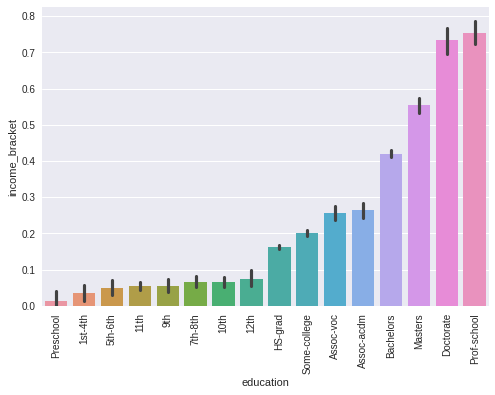

In [14]:
ax = sns.barplot(x='education', y='income_bracket', data=df, order=order);
# rotate the axis tick labels for clarity (otherwise they would overlap)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

## Data Preprocessing

**Encode the categorical columns using an appropriate strategy**

In [15]:
# Label Encoding
# cols = df.select_dtypes(object).columns
# df_encoded = df.copy()
# df_encoded[cols] = df_encoded[cols].transform(lambda x: x.astype('category').cat.codes)
# df_encoded

In [16]:
# One-Hot Encoding
# For simplicity, we'll one-hot encode all the columns
# One-hot encoding is a better choice because our categories are nominal
df_encoded = pd.get_dummies(df, columns=df.select_dtypes(object).columns)
df_encoded

,age,capital_gain,capital_loss,hours_per_week,income_bracket,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,39,2174,0,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,0,0,13,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,38,0,0,40,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,0,0,40,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,0,0,40,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,0,0,40,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
48837,39,0,0,36,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
48839,38,0,0,50,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
48840,44,5455,0,40,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Columns: 103 entries, age to native_country_Yugoslavia
dtypes: int64(4), int8(1), uint8(98)
memory usage: 7.2 MB


## Modelling

**Split the data into training and testing sets, and then train the Logistic Regression, K-NN, and Naive Bayes Classifiers on the training set**

[Scikit-learn API Reference](https://scikit-learn.org/stable/modules/classes.html)

In [18]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('income_bracket', axis=1)
y = df_encoded['income_bracket']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

lr_model = LogisticRegression()
knn_model = KNeighborsClassifier()
nb_model = GaussianNB()

In [20]:
# Logistic regression fails to converge with this dataset
# We may need to apply scaling/normalization
# It could also be that the dataset is not linearly separable
# Since this is a linear model, validation techinques like the ones used in lab 5 can be used
lr_model.fit(X_train, y_train)

knn_model.fit(X_train, y_train)

nb_model.fit(X_train, y_train)

/home/hazem/miniconda3/lib/python3.8/site-packages/scikit_learn-0.23.2-py3.8-linux-x86_64.egg/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GaussianNB()

## Evaluation

**Evaluate each model using their built-in `score` function**

`score` outputs the accuracy score of each model.

Since each class is important to us and the data is not too imbalanced (75% <=50k and 25% >50k), we'll use accuracy as our measure. In this case, KNN performs the best. This is with the default values of each model however, so we can use cross-validation in order to try out different parameters and then finally evaluate using the testing dataset.

In [21]:
lr_model.score(X_test, y_test)

0.8418957765165475

In [22]:
knn_model.score(X_test, y_test)

0.8425591508808138

In [23]:
nb_model.score(X_test, y_test)

0.7968600280091398

## References

Dataset source: https://archive.ics.uci.edu/ml/datasets/census+income